<a href="https://colab.research.google.com/github/arvindsuresh-math/Fall-2025-Team-Big-Data/blob/main/notebooks/modeling_oct_20_multiplicative_price_per_person.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment 1: Additive Model for Price-Per-Person (Baseline)

## 1. Objective

The goal of this notebook is to establish a performance baseline for predicting the `price_per_person` of an Airbnb listing. This experiment uses a purely additive, multi-axis neural network, which is designed for high explainability.

## 2. Methodology

*   **Model Architecture:** An additive neural network with 6 parallel sub-networks, one for each of the following feature axes:
    1.  Location
    2.  Size & Capacity
    3.  Quality & Reputation
    4.  Amenities (Text)
    5.  Description (Text)
    6.  Seasonality
*   **Target Variable:** `price_per_person` (untransformed, in dollars).
*   **Loss Function:** Root Mean Squared Error (RMSE), which optimizes for direct dollar-space error. This model does not use sample weighting.

## 3. Key Features

*   **Modular Code:** The notebook is structured with distinct classes for configuration, feature processing, data loading, and modeling to ensure clarity and reusability.
*   **End-to-End Pipeline:** A single `main()` function orchestrates the entire workflow from data loading to model training and artifact saving.
*   **Robust Training:** The training loop includes early stopping to prevent overfitting and saves the best model based on validation performance.
*   **Performance Analysis:** After training, the model's performance is evaluated by calculating the Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE) across different price-per-person brackets.

## 4. Expected Outcome

This notebook will produce a trained model artifact (`.pt` file) and a detailed performance report. This baseline will serve as the benchmark against which more complex models (e.g., those using log-transformed targets) will be compared.

#### **0. Setup and Installations**

In [1]:
# --- Hugging Face Authentication (using Colab Secrets) ---
from google.colab import userdata
from huggingface_hub import login
print("Attempting Hugging Face login...")
try:
    HF_TOKEN = userdata.get('HF_TOKEN')
    login(token=HF_TOKEN)
    print("Hugging Face login successful.")
except Exception as e:
    print(f"Could not log in. Please ensure 'HF_TOKEN' is a valid secret. Error: {e}")

Attempting Hugging Face login...
Hugging Face login successful.


In [2]:
# --- Mount Google Drive ---
from google.colab import drive
print("Mounting Google Drive...")
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Could not mount Google Drive. Error: {e}")

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted successfully.


In [3]:
# --- Install Dependencies ---
!pip install pandas
!pip install pyarrow
!pip install sentence-transformers
!pip install scikit-learn
!pip install torch
!pip install tqdm
!pip install transformers
!pip install matplotlib
!pip install seaborn

### **1. Configuration and Helper Functions**

This section defines the experiment's configuration using a simple Python dictionary, which is direct and easy to modify. The `set_seed` utility is retained for reproducibility.

In [4]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# --- Seeding function for reproducibility ---
def set_seed(seed: int):
    """Sets random seeds for numpy and torch for reproducible results."""
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"All random seeds set to {seed}.")

In [6]:
# --- Simplified Configuration using a Dictionary ---
config = {
    # --- Data and Environment ---
    "CITY": "nyc",
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    "DRIVE_SAVE_PATH": "/content/drive/MyDrive/Colab_Notebooks/Airbnb_Project/",
    "TEXT_MODEL_NAME": 'BAAI/bge-small-en-v1.5',

    # --- Data Pre-processing ---
    "VAL_SIZE": 0.2,

    # --- Reproducibility ---
    "SEED": 42,

    # --- Model Training ---
    "BATCH_SIZE": 256,
    "VALIDATION_BATCH_SIZE": 512, # NEW: Separate, larger batch size for validation
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 50,

    # --- Early Stopping ---
    "EARLY_STOPPING_PATIENCE": 5,
    "EARLY_STOPPING_MIN_DELTA": 0.001, # Adjusted for log-space error (0.1%)

    # --- Learning Rate Scheduler ---
    "SCHEDULER_PATIENCE": 2,
    "SCHEDULER_FACTOR": 0.5,
}

### **2. Data Loading and Splitting**

This function is a critical part of the modeling process. **Stratified splitting is retained** to ensure that the validation set is representative of the training data, which is crucial for obtaining a reliable measure of the model's performance.

In [7]:
def load_and_split_data(config: dict):
    """
    Loads data, removes price outliers, and performs a stratified split.
    This is a core ML practice that is retained for model correctness.
    """
    dataset_filename = f"{config['CITY']}_dataset_oct_17.parquet"
    dataset_path = f"./{dataset_filename}"
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"'{dataset_filename}' not found. Please upload the file.")

    print(f"Loading dataset from: {dataset_path}")
    df = pd.read_parquet(dataset_path)
    df = df[df["price_per_person"] > 0].copy()

    # Create bins for stratifying continuous price_per_person
    df['price_bin'] = pd.qcut(df['price_per_person'], q=10, labels=False, duplicates='drop')
    stratify_key = (
        df['neighbourhood_cleansed'].astype(str) + '_' +
        df['month'].astype(str) + '_' +
        df['price_bin'].astype(str)
    )

    strata_counts = stratify_key.value_counts()
    valid_strata = strata_counts[strata_counts >= 2].index
    df_filtered = df[stratify_key.isin(valid_strata)].copy()
    print(f"Removed small strata. New size: {len(df_filtered):,} records.")

    train_indices, val_indices = train_test_split(
        df_filtered.index,
        test_size=config['VAL_SIZE'],
        random_state=config['SEED'],
        stratify=stratify_key[df_filtered.index]
    )

    train_df = df_filtered.loc[train_indices].reset_index(drop=True)
    val_df = df_filtered.loc[val_indices].reset_index(drop=True)

    print(f"Split complete. Training: {len(train_df):,}, Validation: {len(val_df):,}")
    return train_df, val_df

### **3. Feature Processor**

The `FeatureProcessor` with its `fit`/`transform` pattern is **retained**. This is fundamental to preventing **data leakage**, where information from the validation set accidentally influences the training process. The vectorized NumPy operations are also kept for performance.

In [8]:
class FeatureProcessor:
    """
    The fit/transform pattern is a fundamental ML best practice to prevent data leakage.
    It is retained to ensure the model's evaluation is valid.
    """
    def __init__(self, embedding_dim_geo: int = 32):
        self.vocabs, self.scalers = {}, {}
        self.embedding_dim_geo = embedding_dim_geo
        self.categorical_cols = ["neighbourhood_cleansed", "property_type", "room_type"]
        self.numerical_cols = ["accommodates", "review_scores_rating", "review_scores_cleanliness",
                               "review_scores_checkin", "review_scores_communication", "review_scores_location",
                               "review_scores_value", "bedrooms", "beds", "bathrooms"]
        self.log_transform_cols = ["total_reviews"]

    def fit(self, df: pd.DataFrame):
        print("Fitting FeatureProcessor...")
        for col in self.categorical_cols:
            valid_uniques = df[col].dropna().unique().tolist()
            self.vocabs[col] = {val: i for i, val in enumerate(["<UNK>"] + sorted(valid_uniques))}
        for col in self.numerical_cols + self.log_transform_cols:
            numeric_series = pd.to_numeric(df[col], errors='coerce')
            mean_val = numeric_series.mean()
            filled_series = numeric_series.fillna(mean_val)
            vals = np.log1p(filled_series) if col in self.log_transform_cols else filled_series
            self.scalers[col] = {'mean': vals.mean(), 'std': vals.std() if vals.std() > 0 else 1.0, 'impute_raw': float(mean_val)}
        print("Fit complete.")

    def transform(self, df: pd.DataFrame) -> dict:
        df = df.copy()
        half_dim = self.embedding_dim_geo // 2
        lat = pd.to_numeric(df["latitude"], errors="coerce").fillna(0).to_numpy(dtype=np.float32)
        lon = pd.to_numeric(df["longitude"], errors="coerce").fillna(0).to_numpy(dtype=np.float32)

        def pe(arr, max_val, d):
            pos = (arr / max_val) * 10000.0
            idx = np.arange(0, d, 2, dtype=np.float32)
            div = np.exp(-(np.log(10000.0) / d) * idx).astype(np.float32)
            s = np.sin(pos[:, None] * div[None, :]).astype(np.float32)
            c = np.cos(pos[:, None] * div[None, :]).astype(np.float32)
            out = np.empty((arr.shape[0], d), dtype=np.float32)
            out[:, 0::2], out[:, 1::2] = s, c
            return out

        geo_position = np.hstack([pe(lat, 90.0, half_dim), pe(lon, 180.0, half_dim)]).astype(np.float32)
        neighbourhood = df["neighbourhood_cleansed"].map(self.vocabs["neighbourhood_cleansed"]).fillna(0).astype(np.int64)

        size_features = {
            "property_type": df["property_type"].map(self.vocabs["property_type"]).fillna(0).astype(np.int64),
            "room_type": df["room_type"].map(self.vocabs["room_type"]).fillna(0).astype(np.int64)
        }
        for col in ["accommodates", "bedrooms", "beds", "bathrooms"]:
            x = pd.to_numeric(df[col], errors='coerce').fillna(self.scalers[col]['impute_raw'])
            size_features[col] = ((x - self.scalers[col]["mean"]) / self.scalers[col]["std"]).astype(np.float32)

        quality_features = {}
        quality_num_cols = set(self.numerical_cols) - set(size_features.keys()) - set(["property_type", "room_type"])
        for col in quality_num_cols:
            x = pd.to_numeric(df[col], errors='coerce').fillna(self.scalers[col]['impute_raw'])
            quality_features[col] = ((x - self.scalers[col]["mean"]) / self.scalers[col]["std"]).astype(np.float32)

        raw = pd.to_numeric(df["total_reviews"], errors="coerce").fillna(self.scalers["total_reviews"]["impute_raw"])
        tr_log = np.log1p(raw).astype(np.float32)
        quality_features["total_reviews"] = (tr_log - self.scalers["total_reviews"]["mean"]) / self.scalers["total_reviews"]["std"]
        quality_features["host_is_superhost"] = df["host_is_superhost"].astype(np.float32)

        month = pd.to_numeric(df["month"], errors="coerce").fillna(1).to_numpy(np.float32)
        season_cyc = np.stack([np.sin(2 * np.pi * month / 12), np.cos(2 * np.pi * month / 12)], axis=1).astype(np.float32)

        return {
            "location": {"geo_position": geo_position, "neighbourhood": neighbourhood.to_numpy()},
            "size_capacity": {k: v.to_numpy() for k, v in size_features.items()},
            "quality": {k: v.to_numpy() for k, v in quality_features.items()},
            "amenities_text": df["amenities"].fillna("").tolist(),
            "description_text": df["description"].fillna("").tolist(),
            "seasonality": {"cyclical": season_cyc},
            # UPDATED: Provide both the original price and the log-transformed price
            "target_price": df["price_per_person"].to_numpy(dtype=np.float32),
            "target_log": np.log1p(df["price_per_person"]).to_numpy(dtype=np.float32),
        }

### **4. PyTorch Dataset and DataLoader**

This section is now much simpler.
*   The `Dataset` class now handles tokenization internally.
*   The `create_dataloaders` function is a simple wrapper that creates standard `DataLoader` instances without any complex configuration. This removes the need for a custom collate function.

In [9]:
class AirbnbPriceDataset(Dataset):
    def __init__(self, features: dict, tokenizer):
        self.features = features
        self.tokenizer = tokenizer
        self.n_samples = len(features['target_price'])

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index: int) -> dict:
        item = {
            'loc_geo_position': torch.tensor(self.features['location']['geo_position'][index], dtype=torch.float32),
            'loc_neighbourhood': torch.tensor(self.features['location']['neighbourhood'][index], dtype=torch.long),
            'season_cyclical': torch.tensor(self.features['seasonality']['cyclical'][index], dtype=torch.float32),
            'target_price': torch.tensor(self.features['target_price'][index], dtype=torch.float32),
            'target_log': torch.tensor(self.features['target_log'][index], dtype=torch.float32)
        }
        for k, v in self.features['size_capacity'].items():
            dtype = torch.long if k in ['property_type', 'room_type'] else torch.float32
            item[f'size_{k}'] = torch.tensor(v[index], dtype=dtype)
        for k, v in self.features['quality'].items():
            item[f'qual_{k}'] = torch.tensor(v[index], dtype=dtype)

        item['amenities_tokens'] = self.tokenizer(self.features['amenities_text'][index], padding='max_length', truncation=True, max_length=128, return_tensors="pt")
        item['description_tokens'] = self.tokenizer(self.features['description_text'][index], padding='max_length', truncation=True, max_length=256, return_tensors="pt")
        return item

def create_dataloaders(train_features: dict, val_features: dict, config: dict):
    """Simplified DataLoader creation."""
    tokenizer = AutoTokenizer.from_pretrained(config['TEXT_MODEL_NAME'], use_fast=True)
    train_dataset = AirbnbPriceDataset(train_features, tokenizer)
    val_dataset = AirbnbPriceDataset(val_features, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=config['BATCH_SIZE'], shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=config['VALIDATION_BATCH_SIZE'], shuffle=False, num_workers=2)

    print("DataLoaders created.")
    return train_loader, val_loader

### **5. Model Architecture**

**This section is updated as requested.**
*   A new method, `forward_with_decomposition`, is added to compute the outputs of all subnets.
*   The original `forward` method now calls this new method and simply returns the final price, keeping the training loop clean. This avoids code duplication while enabling the detailed output needed for inference.

In [10]:
from sentence_transformers import SentenceTransformer

class AdditiveAxisModel(nn.Module):
    def __init__(self, processor: FeatureProcessor, config: dict, mean_target_log_price: float):
        super().__init__()
        self.device = config['DEVICE']
        # --- Embeddings ---
        self.embed_neighbourhood = nn.Embedding(len(processor.vocabs['neighbourhood_cleansed']), 16)
        self.embed_property_type = nn.Embedding(len(processor.vocabs['property_type']), 8)
        self.embed_room_type = nn.Embedding(len(processor.vocabs['room_type']), 4)
        # --- Text Transformer ---
        self.text_transformer = SentenceTransformer(config['TEXT_MODEL_NAME'], device=self.device)
        for param in self.text_transformer.parameters():
            param.requires_grad = False

        # Subnets are broken into body (for hidden states) and head (for prediction)
        self.loc_subnet_body = nn.Sequential(nn.Linear(48, 32), nn.ReLU())
        self.loc_subnet_head = nn.Linear(32, 1)

        self.size_subnet_body = nn.Sequential(nn.Linear(16, 32), nn.ReLU())
        self.size_subnet_head = nn.Linear(32, 1)

        self.qual_subnet_body = nn.Sequential(nn.Linear(8, 32), nn.ReLU())
        self.qual_subnet_head = nn.Linear(32, 1)

        self.amenities_subnet_body = nn.Sequential(nn.Linear(384, 32), nn.ReLU())
        self.amenities_subnet_head = nn.Linear(32, 1)

        self.desc_subnet_body = nn.Sequential(nn.Linear(384, 32), nn.ReLU())
        self.desc_subnet_head = nn.Linear(32, 1)

        self.season_subnet_body = nn.Sequential(nn.Linear(2, 16), nn.ReLU())
        self.season_subnet_head = nn.Linear(16, 1)

        self.register_buffer('global_bias', torch.tensor([mean_target_log_price], dtype=torch.float32))
        self.to(self.device)

    # 1. Base method: Returns everything (for clustering later)
    def forward_with_hidden_states(self, batch: dict) -> dict:
        """Performs a full forward pass and returns predictions, contributions, and hidden states."""
        loc_input = torch.cat([batch['loc_geo_position'], self.embed_neighbourhood(batch['loc_neighbourhood'])], dim=1)
        size_input = torch.cat([
            self.embed_property_type(batch['size_property_type']), self.embed_room_type(batch['size_room_type']),
            batch['size_accommodates'].unsqueeze(1), batch['size_bedrooms'].unsqueeze(1),
            batch['size_beds'].unsqueeze(1), batch['size_bathrooms'].unsqueeze(1)], dim=1)
        qual_cols = ["review_scores_rating", "review_scores_cleanliness", "review_scores_checkin",
                     "review_scores_communication", "review_scores_location", "review_scores_value",
                     "total_reviews", "host_is_superhost"]
        qual_input = torch.cat([batch[f'qual_{c}'].unsqueeze(1) for c in qual_cols], dim=1)

        with torch.inference_mode():
            amenities_tokens = {k: v.squeeze(1) for k, v in batch['amenities_tokens'].items()}
            desc_tokens = {k: v.squeeze(1) for k, v in batch['description_tokens'].items()}
            amenities_embed = self.text_transformer(amenities_tokens)['sentence_embedding']
            desc_embed = self.text_transformer(desc_tokens)['sentence_embedding']

        h_loc = self.loc_subnet_body(loc_input)
        h_size = self.size_subnet_body(size_input)
        h_qual = self.qual_subnet_body(qual_input)
        h_amenities = self.amenities_subnet_body(amenities_embed)
        h_desc = self.desc_subnet_body(desc_embed)
        h_season = self.season_subnet_body(batch['season_cyclical'])

        p_loc = self.loc_subnet_head(h_loc)
        p_size = self.size_subnet_head(h_size)
        p_qual = self.qual_subnet_head(h_qual)
        p_amenities = self.amenities_subnet_head(h_amenities)
        p_desc = self.desc_subnet_head(h_desc)
        p_season = self.season_subnet_head(h_season)

        predicted_log = (self.global_bias + p_loc + p_size + p_qual + p_amenities + p_desc + p_season)

        return {
            'predicted_log': predicted_log.squeeze(-1),
            'global_bias': self.global_bias.expand(predicted_log.size(0)),
            'p_location': p_loc.squeeze(-1),
            'p_size_capacity': p_size.squeeze(-1),
            'p_quality': p_qual.squeeze(-1),
            'p_amenities': p_amenities.squeeze(-1),
            'p_description': p_desc.squeeze(-1),
            'p_seasonality': p_season.squeeze(-1),
            'h_location': h_loc,
            'h_size_capacity': h_size,
            'h_quality': h_qual,
            'h_amenities': h_amenities,
            'h_description': h_desc,
            'h_seasonality': h_season,
        }

    # 2. Analysis method: Returns only price-related components
    def forward_with_price(self, batch: dict) -> dict:
        """Calls the base method and returns only the price decomposition."""
        all_outputs = self.forward_with_hidden_states(batch)
        # Filter out the hidden state ('h_') keys
        price_outputs = {k: v for k, v in all_outputs.items() if not k.startswith('h_')}
        return price_outputs

    # 3. Standard method: Returns only the final prediction tensor (for training/loss)
    def forward(self, batch: dict) -> torch.Tensor:
        """The standard forward pass for training, returning only the final prediction tensor."""
        return self.forward_with_hidden_states(batch)['predicted_log']

### **6. Training and Evaluation Functions**

**This section is updated as requested.**
*   The `evaluate_model` function now calculates and returns both validation loss (MSE) and **validation MAPE**.
*   The `train_model` function now uses **validation MAPE for its early stopping logic**, which aligns the training objective more closely with your desired outcome.

In [11]:
def evaluate_model(model, data_loader, device):
    """UPDATED: Calculates MSE on log-price and MAPE on price."""
    model.eval()
    total_loss = 0.0
    total_mape = 0.0
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Validating", leave=False):
            for k, v in batch.items():
                batch[k] = v.to(device) if isinstance(v, torch.Tensor) else {sk: sv.to(device) for sk, sv in v.items()}
            targets_price = batch['target_price']
            targets_log = batch['target_log']

            with torch.amp.autocast(device_type=device, dtype=torch.float16, enabled=(device=="cuda")):
                predictions_log = model(batch)
                # Loss is MSE in log space
                loss = torch.mean((predictions_log - targets_log).float().pow(2))

                # For MAPE, convert predictions and targets back to price space
                price_preds = torch.expm1(predictions_log)
                mape = (torch.abs(price_preds - targets_price) / (targets_price + 1e-6)).mean()

            total_loss += loss.item()
            total_mape += mape.item()

    return total_loss / len(data_loader), total_mape / len(data_loader)


def train_model(model, train_loader, val_loader, optimizer, scheduler, config):
    """UPDATED: Logging format changed to RMSE and patience bug fixed."""
    print("\n--- Starting Model Training ---")
    history, best_val_mape = [], float('inf')
    best_model_state, patience_counter = None, 0
    scaler = torch.amp.GradScaler(enabled=(config['DEVICE'] == "cuda"))
    start_time = time.time()

    header = f"{'Epoch':>5} | {'Time':>8} | {'Train RMSE':>12} | {'Val RMSE':>10} | {'Val MAPE (%)':>12} | {'Patience':>8}"
    print(header)
    print("-" * len(header))

    for epoch in range(config['N_EPOCHS']):
        model.train()
        train_loss_epoch = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['N_EPOCHS']}", leave=False):
            for k, v in batch.items():
                batch[k] = v.to(config['DEVICE']) if isinstance(v, torch.Tensor) else {sk: sv.to(config['DEVICE']) for sk, sv in v.items()}
            targets_log = batch["target_log"]

            with torch.amp.autocast(device_type=config['DEVICE'], dtype=torch.float16, enabled=(config['DEVICE']=="cuda")):
                preds_log = model(batch)
                loss = torch.mean((preds_log - targets_log).float().pow(2))

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss_epoch += loss.item()

        val_mse, val_mape = evaluate_model(model, val_loader, config['DEVICE'])

        train_rmse = np.sqrt(train_loss_epoch / len(train_loader))
        val_rmse = np.sqrt(val_mse)

        elapsed_time = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))

        # BUG FIX: Update patience *before* printing the log line.
        if val_mape < best_val_mape - config['EARLY_STOPPING_MIN_DELTA']:
            best_val_mape = val_mape
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1

        log_line = (f"{epoch+1:>5} | {elapsed_time:>8} | {train_rmse:>12.4f} | {val_rmse:>10.4f} | {val_mape*100:>12.2f} | {patience_counter:>8}")
        print(log_line)

        history.append({'epoch': epoch, 'train_rmse': train_rmse, 'val_rmse': val_rmse, 'val_mape': val_mape})
        scheduler.step(val_mape)

        if patience_counter >= config['EARLY_STOPPING_PATIENCE']:
            print(f"--- Early Stopping Triggered (MAPE did not improve) ---")
            break

    print("\n--- Training Complete ---")
    if best_model_state:
        model.load_state_dict(best_model_state)
    return model, pd.DataFrame(history)

### **7. Inference, Saving, and Analysis**

**This section is updated as requested.**
*   A new inference function, `run_inference_with_decomposition`, calls the model's corresponding new forward method. It returns a dictionary of NumPy arrays, one for the final prediction and one for each subnet.
*   The analysis function, `analyze_results`, now creates the **binned MAPE visualization**.
*   The saving function remains simple.

In [12]:
def run_inference_with_details(model, data_loader, device):
    """UPDATED: Calls the forward_with_price method to get the decomposition."""
    model.eval()
    outputs = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Running Inference with Details", leave=False):
            for k, v in batch.items():
                batch[k] = v.to(device) if isinstance(v, torch.Tensor) else {sk: sv.to(device) for sk, sv in v.items()}
            # UPDATED: Call the method that returns only the price decomposition.
            batch_outputs = model.forward_with_price(batch)
            outputs.append({k: v.cpu() for k, v in batch_outputs.items()})

    final_outputs = {}
    for key in outputs[0].keys():
        final_outputs[key] = torch.cat([o[key] for o in outputs]).numpy()

    final_outputs['predicted_price'] = np.expm1(final_outputs['predicted_log'])
    return final_outputs

def save_artifacts_simple(model, processor, config):
    """Simplified artifact saving."""
    timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
    filename = f"{config['CITY']}_model_artifacts_{timestamp}.pt"
    save_path = os.path.join(config['DRIVE_SAVE_PATH'], filename)
    os.makedirs(config['DRIVE_SAVE_PATH'], exist_ok=True)

    torch.save({
        'model_state_dict': model.state_dict(),
        'feature_processor': processor,
        'config': config
    }, save_path)
    print(f"\nArtifacts saved to {save_path}")

def analyze_results(df_with_preds, original_val_df):
    """
    Interprets and visualizes the decomposition for a multiplicative model.
    """
    mae = (df_with_preds['predicted_price'] - df_with_preds['price_per_person']).abs().mean()
    print(f"\n--- Final Performance (Validation Set) ---")
    print(f"Mean Absolute Error: ${mae:.2f}")

    # --- Scatter Plot & Binned MAPE ---
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x='price_per_person', y='predicted_price', data=df_with_preds.sample(min(len(df_with_preds), 2000)), alpha=0.5)
    plt.plot([0, df_with_preds['price_per_person'].max()], [0, df_with_preds['price_per_person'].max()], color='red', linestyle='--')
    plt.title("True vs. Predicted Prices"), plt.xlabel("True Price per Person ($)"), plt.ylabel("Predicted Price per Person ($)"), plt.grid(True), plt.show()

    df_analysis = df_with_preds.copy()
    df_analysis['mape'] = (df_analysis['predicted_price'] - df_analysis['price_per_person']).abs() / (df_analysis['price_per_person'] + 1e-6) * 100
    max_price = min(200, df_analysis['price_per_person'].max())
    bins = np.arange(0, max_price + 10, 10)
    df_analysis['price_bin'] = pd.cut(df_analysis['price_per_person'], bins=bins, right=False)
    binned_mape = df_analysis.groupby('price_bin', observed=False)['mape'].mean().reset_index()

    plt.figure(figsize=(12, 6))
    sns.barplot(x='price_bin', y='mape', data=binned_mape, palette='viridis'), plt.title("Mean Absolute Percentage Error (MAPE) by Price Bracket")
    plt.xlabel("Price per Person Bracket ($)"), plt.ylabel("MAPE (%)"), plt.xticks(rotation=45), plt.grid(axis='y'), plt.show()

    # --- Analyze Multiplicative Decomposition ---
    print("\n" + "="*50), print("--- Analysis of Multiplicative Decomposition ---"), print("="*50)

    p_cols = [col for col in df_with_preds.columns if col.startswith('p_') or col == 'global_bias']
    decomposition_stats = df_with_preds[p_cols].mean().sort_values(ascending=False)

    print("Average Additive Contribution of Each Component to the Log-Price:")
    print(decomposition_stats)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=decomposition_stats.values, y=decomposition_stats.index, orient='h')
    plt.title("Average Contribution to Log-Price by Model Subnet")
    plt.xlabel("Average Contribution to Log-Price"), plt.ylabel("Model Component"), plt.grid(axis='x'), plt.show()

    # --- Detailed Error Analysis for Multiplicative Model ---
    print("\n" + "="*50), print("--- Detailed Analysis of Top 3 Worst Predictions (by MAPE) ---"), print("="*50)

    df_analysis_full = pd.concat([df_analysis.reset_index(drop=True), original_val_df[['amenities', 'description']].reset_index(drop=True)], axis=1)
    worst_preds = df_analysis_full.nlargest(3, 'mape')

    for i, (idx, row) in enumerate(worst_preds.iterrows()):
        print(f"\n--- Worst Prediction #{i+1} (Index: {idx}) ---")
        print("\nKey Features:"), print(f"  - Neighbourhood: {row['neighbourhood_cleansed']}, Property: {row['property_type']}, Room: {row['room_type']}")
        print(f"  - Accommodates: {row['accommodates']}, Bedrooms: {row['bedrooms']}, Reviews: {int(row['total_reviews'])}")

        print("\nPrice & Error:"), print(f"  - True Price:      ${row['price_per_person']:.2f}"), print(f"  - Predicted Price: ${row['predicted_price']:.2f}")
        print(f"  - MAPE:            {row['mape']:.2f}%")

        print("\nMultiplicative Price Breakdown:")
        total_check_log = 0
        for col in p_cols:
            multiplicative_factor = np.exp(row[col])
            print(f"  - {col:<16}: {row[col]:.3f} (multiplies price by {multiplicative_factor:.2f}x)")
            total_check_log += row[col]
        print(f"  - {'-'*15}: {'-'*28}")
        print(f"  - {'Predicted Log-Price':<16}: {total_check_log:.3f} (Predicted Price = exp({total_check_log:.3f}) - 1 = ${np.expm1(total_check_log):.2f})")

### **8. Main Orchestration and Execution**

The `main` function is updated to use the new decomposition inference function and to correctly add the multiple new columns to the final DataFrame before passing it to the updated analysis function.

In [13]:
def main(config: dict):
    """
    UPDATED: Orchestrates the multiplicative model pipeline.
    """
    # 1. Load and split data
    train_df, val_df = load_and_split_data(config)
    # UPDATED: The global bias for the model is now the mean of the log-transformed price.
    mean_target_log = np.log1p(train_df['price_per_person']).mean()

    # 2. Setup processor and dataloaders
    processor = FeatureProcessor()
    processor.fit(train_df)
    train_features = processor.transform(train_df)
    val_features = processor.transform(val_df)
    train_loader, val_loader = create_dataloaders(train_features, val_features, config)

    # 3. Initialize model and optimizer
    model = AdditiveAxisModel(processor, config, mean_target_log_price=mean_target_log)
    optimizer = optim.AdamW(model.parameters(), lr=config['LEARNING_RATE'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=config['SCHEDULER_FACTOR'], patience=config['SCHEDULER_PATIENCE'])

    # 4. Train the model
    trained_model, history = train_model(model, train_loader, val_loader, optimizer, scheduler, config)

    # 5. Run final inference on the validation set to get all details
    details_outputs = run_inference_with_details(trained_model, val_loader, config['DEVICE'])

    # Add all decomposition and hidden state columns to the validation dataframe
    val_df_with_details = val_df.copy()
    for key, value in details_outputs.items():
        val_df_with_details[key] = list(value) # Use list() to handle array columns

    # 6. Save artifacts and analyze results
    save_artifacts_simple(trained_model, processor, config)
    analyze_results(val_df_with_details, val_df)

    # Package all key results into a dictionary and return it.
    artifacts = {
        'model': trained_model,
        'processor': processor,
        'val_df_with_details': val_df_with_details,
        'history': history,
        'config': config
    }
    return artifacts

All random seeds set to 42.
Loading dataset from: ./nyc_dataset_oct_17.parquet
Removed small strata. New size: 144,449 records.
Split complete. Training: 115,559, Validation: 28,890
Fitting FeatureProcessor...
Fit complete.


tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

DataLoaders created.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


--- Starting Model Training ---
Epoch |     Time |   Train RMSE |   Val RMSE | Val MAPE (%) | Patience
----------------------------------------------------------------------


Epoch 1/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

    1 | 00:01:58 |       0.4221 |     0.3639 |        28.42 |        0


Epoch 2/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

    2 | 00:03:54 |       0.3562 |     0.3439 |        27.72 |        0


Epoch 3/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

    3 | 00:05:49 |       0.3440 |     0.3343 |        26.47 |        0


Epoch 4/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

    4 | 00:07:45 |       0.3366 |     0.3270 |        25.85 |        0


Epoch 5/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

    5 | 00:09:42 |       0.3305 |     0.3216 |        25.22 |        0


Epoch 6/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

    6 | 00:11:38 |       0.3244 |     0.3161 |        24.94 |        0


Epoch 7/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

    7 | 00:13:34 |       0.3197 |     0.3110 |        24.35 |        0


Epoch 8/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

    8 | 00:15:31 |       0.3168 |     0.3108 |        23.81 |        0


Epoch 9/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

    9 | 00:17:27 |       0.3133 |     0.3030 |        23.88 |        1


Epoch 10/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

   10 | 00:19:24 |       0.3099 |     0.3002 |        23.94 |        2


Epoch 11/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

   11 | 00:21:20 |       0.3070 |     0.2966 |        24.22 |        3


Epoch 12/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

   12 | 00:23:17 |       0.3030 |     0.2944 |        22.92 |        0


Epoch 13/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

   13 | 00:25:13 |       0.3015 |     0.2916 |        24.07 |        1


Epoch 14/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

   14 | 00:27:09 |       0.3002 |     0.2905 |        22.90 |        2


Epoch 15/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

   15 | 00:29:06 |       0.2993 |     0.2895 |        23.72 |        3


Epoch 16/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

   16 | 00:31:02 |       0.2981 |     0.2892 |        22.58 |        0


Epoch 17/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

   17 | 00:32:58 |       0.2969 |     0.2864 |        22.74 |        1


Epoch 18/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

   18 | 00:34:54 |       0.2963 |     0.2853 |        22.48 |        0


Epoch 19/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

   19 | 00:36:51 |       0.2955 |     0.2836 |        22.55 |        1


Epoch 20/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

   20 | 00:38:47 |       0.2942 |     0.2841 |        22.15 |        0


Epoch 21/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

   21 | 00:40:44 |       0.2934 |     0.2813 |        22.51 |        1


Epoch 22/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

   22 | 00:42:40 |       0.2925 |     0.2839 |        21.68 |        0


Epoch 23/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

   23 | 00:44:37 |       0.2917 |     0.2831 |        21.64 |        1


Epoch 24/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

   24 | 00:46:33 |       0.2899 |     0.2844 |        21.54 |        0


Epoch 25/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

   25 | 00:48:29 |       0.2896 |     0.2799 |        21.50 |        1


Epoch 26/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

   26 | 00:50:25 |       0.2887 |     0.2813 |        21.47 |        2


Epoch 27/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

   27 | 00:52:21 |       0.2882 |     0.2782 |        21.48 |        3


Epoch 28/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

   28 | 00:54:18 |       0.2876 |     0.2746 |        22.02 |        4


Epoch 29/50:   0%|          | 0/452 [00:00<?, ?it/s]

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

   29 | 00:56:14 |       0.2871 |     0.2746 |        22.37 |        5
--- Early Stopping Triggered (MAPE did not improve) ---

--- Training Complete ---


Running Inference with Details:   0%|          | 0/57 [00:00<?, ?it/s]


Artifacts saved to /content/drive/MyDrive/Colab_Notebooks/Airbnb_Project/nyc_model_artifacts_20251020_131033.pt

--- Final Performance (Validation Set) ---
Mean Absolute Error: $15.29


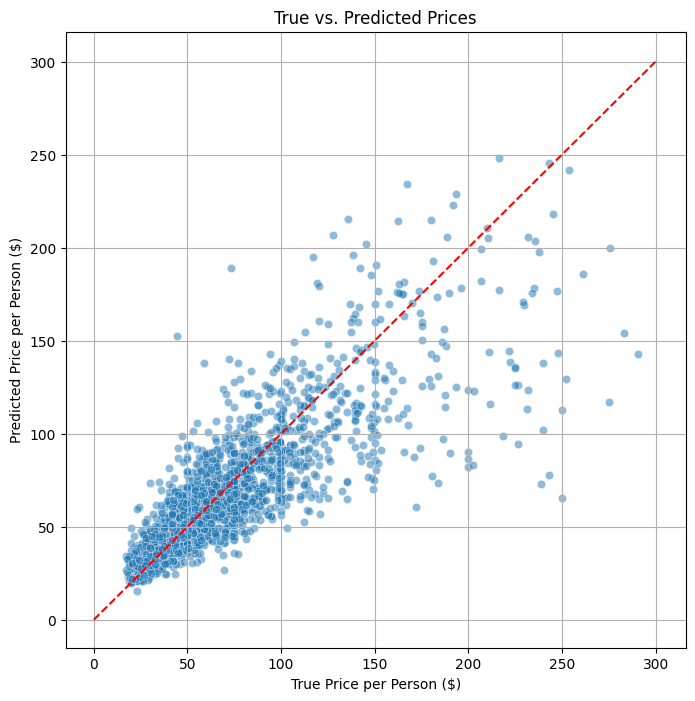

/tmp/ipython-input-636970550.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='price_bin', y='mape', data=binned_mape, palette='viridis'), plt.title("Mean Absolute Percentage Error (MAPE) by Price Bracket")


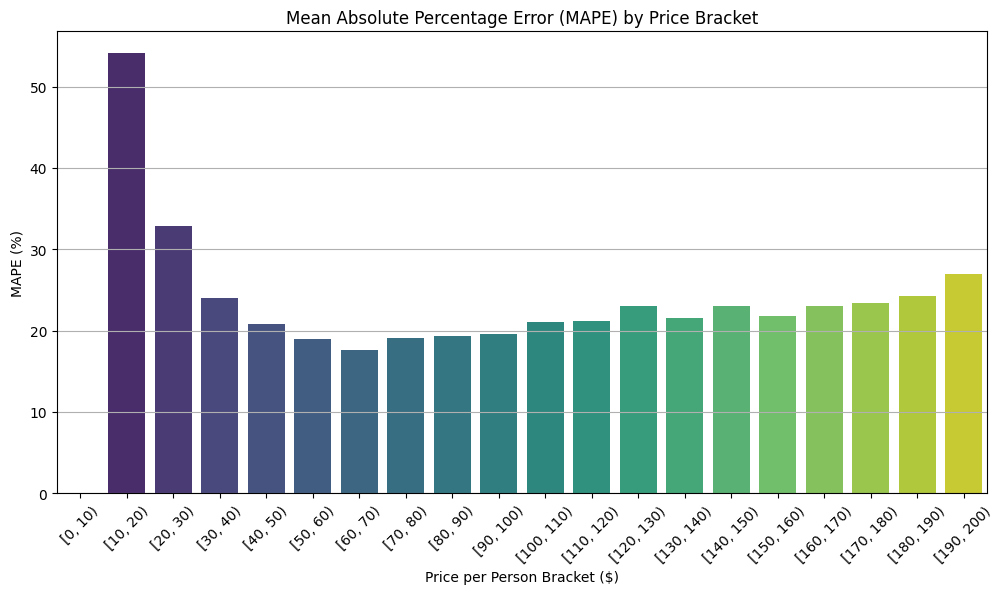


--- Analysis of Multiplicative Decomposition ---
Average Additive Contribution of Each Component to the Log-Price:
global_bias        4.099507
p_size_capacity    0.235220
p_location         0.187151
p_seasonality      0.173626
p_quality         -0.038628
p_amenities       -0.224388
p_description     -0.319064
dtype: float32


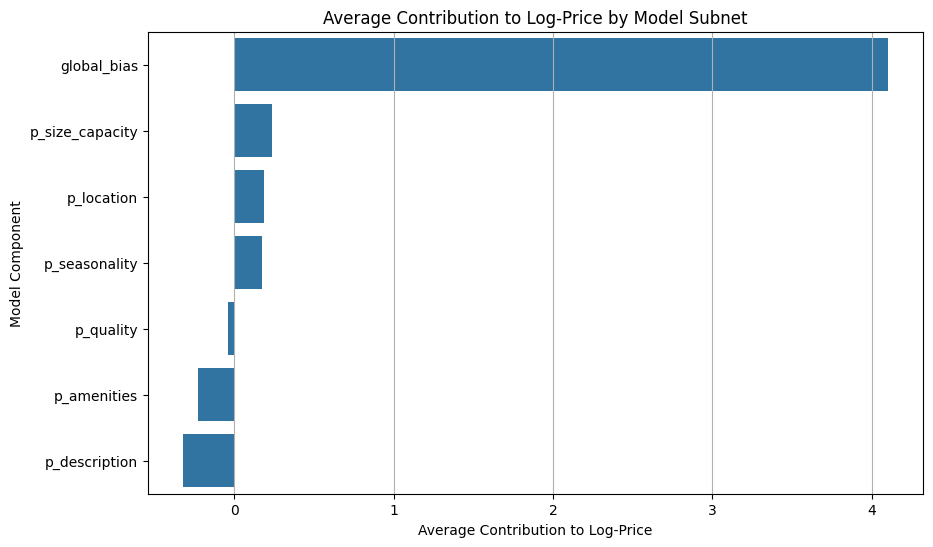


--- Detailed Analysis of Top 3 Worst Predictions (by MAPE) ---

--- Worst Prediction #1 (Index: 16733) ---

Key Features:
  - Neighbourhood: Lower East Side, Property: Entire rental unit, Room: Entire home/apt
  - Accommodates: 3, Bedrooms: 1, Reviews: 4

Price & Error:
  - True Price:      $18.00
  - Predicted Price: $74.52
  - MAPE:            314.01%

Multiplicative Price Breakdown:
  - global_bias     : 4.100 (multiplies price by 60.31x)
  - p_location      : 0.537 (multiplies price by 1.71x)
  - p_size_capacity : 0.217 (multiplies price by 1.24x)
  - p_quality       : -0.108 (multiplies price by 0.90x)
  - p_amenities     : -0.194 (multiplies price by 0.82x)
  - p_description   : -0.409 (multiplies price by 0.66x)
  - p_seasonality   : 0.182 (multiplies price by 1.20x)
  - ---------------: ----------------------------
  - Predicted Log-Price: 4.324 (Predicted Price = exp(4.324) - 1 = $74.52)

--- Worst Prediction #2 (Index: 4579) ---

Key Features:
  - Neighbourhood: Flatiron Dis

In [14]:
# --- Run Full Experiment ---
set_seed(config['SEED'])
artifacts = main(config)

### **1. Setup and Data Preparation**

First, let's extract the necessary data from your `artifacts` dictionary and prepare it for the fast, on-the-fly calculations. This cell extracts the hidden states (`h_...`) and price contributions (`p_...`) from the validation DataFrame and converts them into efficient NumPy matrices. This is a one-time pre-computation.

In [15]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

# --- Extract data from your existing artifacts dictionary ---
val_df = artifacts['val_df_with_details']
config = artifacts['config']

print(f"Preparing data for {len(val_df)} listings in the validation set...")

# --- Prepare Hidden States (The "What") ---
# Convert columns of arrays into large (N_listings, D_hidden) NumPy matrices for fast computation.
hidden_states = {}
h_cols = [col for col in val_df.columns if col.startswith('h_')]
for col in h_cols:
    axis_name = col.replace('h_', '')
    hidden_states[axis_name] = np.stack(val_df[col].values)

print("\nPrepared hidden state matrices for the following axes:")
for name, matrix in hidden_states.items():
    print(f"  - {name}: shape {matrix.shape}")

# --- Prepare Price Contributions (The "Why") ---
# This will be used to calculate the axis-importances for any given listing.
price_contributions = {}
p_cols = [col for col in val_df.columns if col.startswith('p_')]
for col in p_cols:
    axis_name = col.replace('p_', '')
    price_contributions[axis_name] = np.stack(val_df[col].values)

print("\nPrepared price contribution vectors for the following axes:")
print(f"  - {list(price_contributions.keys())}")

# For easy access to other listing info
listing_info = val_df[['price_per_person', 'predicted_price', 'neighbourhood_cleansed', 'property_type', 'room_type']]

Preparing data for 28890 listings in the validation set...

Prepared hidden state matrices for the following axes:

Prepared price contribution vectors for the following axes:
  - ['location', 'size_capacity', 'quality', 'amenities', 'description', 'seasonality']


### **2. Helper Functions: Axis-Importance and Distances**

These are the core building blocks of the search.
1.  **`calculate_axis_importances`:** Takes the price contributions for a single listing and returns the normalized weights.
2.  **Distance Functions:** Vectorized functions to compute Euclidean and Cosine distances efficiently.

In [16]:
def calculate_axis_importances(p_contributions_single_listing: dict) -> dict:
    """
    Calculates the normalized weights for each axis based on the absolute
    magnitude of its price contribution.
    """
    abs_contributions = {k: abs(v) for k, v in p_contributions_single_listing.items()}
    total_abs_contribution = sum(abs_contributions.values())

    if total_abs_contribution == 0:
        # Handle the edge case of zero contributions by assigning uniform weight
        num_axes = len(p_contributions_single_listing)
        return {k: 1.0 / num_axes for k in p_contributions_single_listing.keys()}

    # Normalize to create weights that sum to 1
    importances = {k: v / total_abs_contribution for k, v in abs_contributions.items()}
    return importances

def euclidean_distance(vector, matrix):
    """Calculates the Euclidean distance from a single vector to all rows in a matrix."""
    return cdist(vector.reshape(1, -1), matrix, 'euclidean').flatten()

def cosine_distance(vector, matrix):
    """Calculates the Cosine distance from a single vector to all rows in a matrix."""
    # cdist returns cosine distance (1 - similarity), which is what we want.
    return cdist(vector.reshape(1, -1), matrix, 'cosine').flatten()

### **3. The Nearest Neighbor Search Function**

This is the main function that implements the logic we designed: on-the-fly calculation, a hybrid distance metric (Cosine for text, Euclidean for others), and normalization of distances before combining them.

In [21]:
def find_nearest_neighbors(query_idx: int, top_k: int = 5):
    """
    Finds the top K nearest neighbors for a given listing using a personalized,
    weighted distance metric based on the model's price decomposition.
    """
    num_listings = len(listing_info)

    # 1. Get the price contributions for the query listing
    query_contributions = {name: p_vec[query_idx] for name, p_vec in price_contributions.items()}

    # 2. Calculate the axis-importance weights for the query listing
    weights = calculate_axis_importances(query_contributions)

    # 3. Calculate and normalize distances for each axis
    final_scores = np.zeros(num_listings)

    for axis, h_matrix in hidden_states.items():
        query_h_vector = h_matrix[query_idx]

        # a. Calculate raw distances using the appropriate metric
        if axis in ["amenities", "description"]:
            raw_dists = cosine_distance(query_h_vector, h_matrix)
        else:
            raw_dists = euclidean_distance(query_h_vector, h_matrix)

        # b. CRUCIAL: Normalize the distances for this axis to a [0, 1] scale
        min_dist = raw_dists.min()
        max_dist = raw_dists.max()

        if max_dist > min_dist:
            normalized_dists = (raw_dists - min_dist) / (max_dist - min_dist)
        else:
            normalized_dists = np.zeros(num_listings) # All distances are identical

        # c. Add the weighted, normalized distance to the final score
        final_scores += weights[axis] * normalized_dists

    # 4. Find the indices of the listings with the lowest scores
    nearest_indices = np.argsort(final_scores)

    # 5. Return the top_k results, excluding the query listing itself (which will always be first)
    return nearest_indices[1 : top_k + 1], weights

### **4. Demonstration and Results Visualization (Updated)**

This final cell contains the updated display function.
*   It now constructs a **Pandas DataFrame** to show the query listing and its top 5 neighbors side-by-side.
*   **Key features** like price, location, and size are included for easy comparison.
*   The crucial **price decomposition columns** (`p_...`) are also shown.
*   The DataFrame is **stylistically formatted** for readability:
    *   The **Query** row is highlighted in yellow.
    *   Numerical columns are formatted to two decimal places.
    *   The price contribution columns have a **color gradient**, making it easy to see positive (green) and negative (red) contributions at a glance.

In [22]:
from IPython.display import display

# This helper function is now updated to create a detailed comparison table.
def display_neighbor_results(query_idx, neighbor_indices, weights, df_with_details):
    """
    A helper function to print the nearest neighbor results in a clean,
    side-by-side table format for easy comparison.
    """

    print("\n" + "="*80)
    print(f"Finding Nearest Neighbors for Listing #{query_idx}")
    print("="*80)

    # --- Print Axis-Importances (Weights) ---
    print("Personalized Axis Importances for Query Listing:")
    sorted_weights = sorted(weights.items(), key=lambda item: item[1], reverse=True)
    for axis, weight in sorted_weights:
        print(f"  - {axis:<15}: {weight:.2%}")

    # --- Prepare the Comparison DataFrame ---

    # 1. Select the indices for the query and its neighbors
    all_indices = [query_idx] + list(neighbor_indices)

    # 2. Define the columns we want to compare
    feature_cols = [
        'price_per_person', 'predicted_price', 'neighbourhood_cleansed',
        'room_type', 'accommodates', 'bedrooms'
    ]
    p_cols = [col for col in df_with_details.columns if col.startswith('p_')]

    # 3. Create the comparison dataframe
    comparison_df = df_with_details.loc[all_indices, feature_cols + p_cols].copy()

    # 4. Add a 'Listing' column to identify the query vs neighbors
    listing_labels = ['Query'] + [f'Neighbor {i+1}' for i in range(len(neighbor_indices))]
    comparison_df.insert(0, 'Listing', listing_labels)
    comparison_df = comparison_df.set_index('Listing')

    # 5. Style the DataFrame for better readability

    # Define formatting for float columns
    float_format = {col: "${:.2f}" for col in ['price_per_person', 'predicted_price']}
    for col in p_cols:
        float_format[col] = "{:.3f}" # Format contributions to 3 decimal places

    # Define a function to highlight the Query row
    def highlight_query(row):
        return ['background-color: yellow' if row.name == 'Query' else '' for _ in row]

    styled_df = comparison_df.style \
        .apply(highlight_query, axis=1) \
        .format(float_format) \
        .background_gradient(cmap='RdYlGn', subset=p_cols, axis=1, vmin=-0.5, vmax=0.5)

    print("\n--- Side-by-Side Comparison ---")
    display(styled_df)

In [23]:
# --- Run the search for a few random examples ---
# The main loop remains the same, but it will now produce the styled tables.
for i in range(3):
    random_idx = np.random.randint(0, len(listing_info))
    neighbor_indices, weights = find_nearest_neighbors(random_idx, top_k=5)
    # Pass the full dataframe to the display function
    display_neighbor_results(random_idx, neighbor_indices, weights, artifacts['val_df_with_details'])


Finding Nearest Neighbors for Listing #25778
Personalized Axis Importances for Query Listing:
  - location       : 21.46%
  - description    : 20.45%
  - quality        : 18.52%
  - amenities      : 18.28%
  - size_capacity  : 12.94%
  - seasonality    : 8.36%

--- Side-by-Side Comparison ---


,price_per_person,predicted_price,neighbourhood_cleansed,room_type,accommodates,bedrooms,p_location,p_size_capacity,p_quality,p_amenities,p_description,p_seasonality
Listing,,,,,,,,,,,,
Query,$150.00,$78.24,Williamsburg,Private room,2,1,0.260,0.157,0.224,-0.221,-0.248,0.101
Neighbor 1,$59.00,$74.74,Upper East Side,Entire home/apt,2,1,0.401,0.419,-0.061,-0.307,-0.428,0.203
Neighbor 2,$71.00,$50.33,Woodhaven,Private room,1,1,-0.043,0.568,-0.038,-0.330,-0.436,0.118
Neighbor 3,$32.50,$29.49,Jamaica,Private room,2,1,-0.116,0.205,-0.132,-0.372,-0.385,0.118
Neighbor 4,$45.00,$31.46,Bedford-Stuyvesant,Private room,2,1,0.072,0.157,-0.120,-0.132,-0.788,0.193
Neighbor 5,$132.00,$93.18,Harlem,Entire home/apt,2,1,0.240,0.404,0.056,-0.395,-0.022,0.164



Finding Nearest Neighbors for Listing #15605
Personalized Axis Importances for Query Listing:
  - location       : 27.12%
  - size_capacity  : 25.75%
  - description    : 24.08%
  - amenities      : 9.84%
  - seasonality    : 8.26%
  - quality        : 4.95%

--- Side-by-Side Comparison ---


,price_per_person,predicted_price,neighbourhood_cleansed,room_type,accommodates,bedrooms,p_location,p_size_capacity,p_quality,p_amenities,p_description,p_seasonality
Listing,,,,,,,,,,,,
Query,$100.50,$81.83,Upper East Side,Entire home/apt,2,0,0.387,0.367,-0.071,-0.140,-0.343,0.118
Neighbor 1,$59.00,$74.74,Upper East Side,Entire home/apt,2,1,0.401,0.419,-0.061,-0.307,-0.428,0.203
Neighbor 2,$71.00,$50.33,Woodhaven,Private room,1,1,-0.043,0.568,-0.038,-0.330,-0.436,0.118
Neighbor 3,$32.50,$29.49,Jamaica,Private room,2,1,-0.116,0.205,-0.132,-0.372,-0.385,0.118
Neighbor 4,$45.00,$31.46,Bedford-Stuyvesant,Private room,2,1,0.072,0.157,-0.120,-0.132,-0.788,0.193
Neighbor 5,$132.00,$93.18,Harlem,Entire home/apt,2,1,0.240,0.404,0.056,-0.395,-0.022,0.164



Finding Nearest Neighbors for Listing #18559
Personalized Axis Importances for Query Listing:
  - location       : 35.23%
  - seasonality    : 18.09%
  - description    : 15.79%
  - amenities      : 15.75%
  - size_capacity  : 13.35%
  - quality        : 1.78%

--- Side-by-Side Comparison ---


,price_per_person,predicted_price,neighbourhood_cleansed,room_type,accommodates,bedrooms,p_location,p_size_capacity,p_quality,p_amenities,p_description,p_seasonality
Listing,,,,,,,,,,,,
Query,$58.00,$64.30,Hell's Kitchen,Entire home/apt,4,1,0.421,-0.160,-0.021,-0.188,-0.189,0.216
Neighbor 1,$59.00,$74.74,Upper East Side,Entire home/apt,2,1,0.401,0.419,-0.061,-0.307,-0.428,0.203
Neighbor 2,$71.00,$50.33,Woodhaven,Private room,1,1,-0.043,0.568,-0.038,-0.330,-0.436,0.118
Neighbor 3,$32.50,$29.49,Jamaica,Private room,2,1,-0.116,0.205,-0.132,-0.372,-0.385,0.118
Neighbor 4,$45.00,$31.46,Bedford-Stuyvesant,Private room,2,1,0.072,0.157,-0.120,-0.132,-0.788,0.193
Neighbor 5,$132.00,$93.18,Harlem,Entire home/apt,2,1,0.240,0.404,0.056,-0.395,-0.022,0.164
